#Загрузка датасета

In [11]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = drive.CreateFile({'id': "1CTY-caxh-aF0PkmY0Olbn4f1ZAq7wHH7"})
file.GetContentFile("augmentDataset.zip")
!unzip -uq "augmentDataset.zip" -d ""

file = drive.CreateFile({'id': "1ONZp-J6nLXr4Ovf3NynmYnwUvN6h3b15"})
file.GetContentFile("centeredDataset.zip")
!unzip -uq "centeredDataset.zip" -d ""
!ls

     |████████████████████████████████| 993kB 6.5MB/s 
adc.json	    centeredDataset.zip  uniondatasetAugment
augmentDataset.zip  sample_data		 uniondatasetCentered


#Параметры

In [0]:
import random
RANDOM_SEED = 87118956 #random.randint(0, 99999999)

DATASET_NAME = "[Dynamic Hand Gesture 14/28 dataset](http://www-rech.telecom-lille.fr/DHGdataset/) + [SHREC’17 Track Dataset](http://www-rech.telecom-lille.fr/shrec2017-hand/) координаты костей в пространстве + агуметация"
DATASET_AUG_ROOT = "uniondatasetAugment/"
DATASET_CENTERED_ROOT = "uniondatasetCentered/"
COUNT_GUESTURE = 14
COUNT_SAMPLES = 10000
COUNT_AUG_EPOCH = 5

PAD = -1

DROPOUT_X = 0.8
DROPOUT_MASK = 0.8

EXPEREMENT_NAME = 'experement_16'
EXPEREMENT_PATH = './%s/'%EXPEREMENT_NAME
EPOCH_COUNT = 200
EPOCH_SIZE = 256
LEARN_RATE = 0.01


ZIP_NAME = '%s.zip'%EXPEREMENT_NAME

In [0]:
from zipfile import ZipFile
import os
from shutil import copyfile

import matplotlib.pyplot as plt

def CreateGraphis(historyTrainAcc, historyTestAcc, historyTrainLoss, historyTestLoss, historyBatchsLoss, countClassesTrain, countClassesTest, directory):
    # Потери пачек
    fig, ax0 = plt.subplots()
    fig.set_size_inches((10, 8))
    ax0.plot(historyBatchsLoss)
    ax0.set_title('Btaches loss')
    ax0.set_ylabel('Loss')
    ax0.set_xlabel('Batch number')
    plt.savefig(directory + '/batchsLoss.png')
    plt.show()

    # Точность
    fig, ax0 = plt.subplots()
    fig.set_size_inches((10, 8))
    ax0.plot(historyTrainAcc)
    ax0.plot(historyTestAcc)
    ax0.set_title('Точность модели')
    ax0.set_ylabel('Точность')
    ax0.set_xlabel('Эпоха')
    ax0.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(directory + '/acc.png')
    plt.show()

    # График функции потери
    fig, ax0 = plt.subplots()
    fig.set_size_inches((10, 8))
    ax0.plot(historyTrainLoss)
    ax0.plot(historyTestLoss)
    ax0.set_title('Model loss')
    ax0.set_ylabel('Loss')
    ax0.set_xlabel('Epoch')
    ax0.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(directory + '/loss.png')
    plt.show()
    
    # Количество примеров в каждом классе
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    fig.set_size_inches((10, 10))
    fig.suptitle("Распределение классов")
    ax0.bar(range(COUNT_GUESTURE), countClassesTrain)
    ax0.set_xlabel('Номер класса')
    ax0.set_ylabel('Количество примеров')
    ax0.set_title('Тренеровочной выборка')
    ax0.grid(True)
    
    ax1.bar(range(COUNT_GUESTURE), countClassesTest)
    ax1.set_xlabel('Номер класса')
    ax1.set_ylabel('Количество примеров')
    ax1.set_title('Тестовая выборка')
    ax1.grid(True)
    
    plt.savefig(directory + '/classesCount.png')
    plt.show()

def OutputResults(historyTrainAcc, historyTestAcc, historyTrainLoss, historyTestLoss, historyBatchsLoss, countClassesTrain, countClassesTest, 
                  nameModel,
                  trainSize, testSize):
    import shutil
    directory = EXPEREMENT_PATH + nameModel
    shutil.rmtree(directory, ignore_errors=True)
    os.makedirs(directory)
    
    
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    
    CreateGraphis(historyTrainAcc, historyTestAcc, historyTrainLoss, historyTestLoss, historyBatchsLoss, countClassesTrain, countClassesTest, directory)
    
    # Create README
    readmeText = "# %s\n"%nameModel
    readmeText += "| Кол-во жестов | Обучающая выборка | Тестовая выборка | Количество эпох | Размер эпохи | Random seed | Dataset |\n"
    readmeText += "| ------------- | ----------------- | ---------------- | --------------- | ------------ | ----------- | ------- |\n"
    readmeText += "| %i | %i | %i | %i | %i | %i | %s |\n\n"%(COUNT_GUESTURE, 
                                                              trainSize, 
                                                              testSize,
                                                              EPOCH_COUNT,
                                                              EPOCH_SIZE,
                                                              RANDOM_SEED,
                                                              DATASET_NAME)
    readmeText += "![](classesCount.png)\n"
    readmeText += "## Результаты\n"
    readmeText += "### Точность\n"
    readmeText += "![](acc.png)\n"
    readmeText += "### Функция потерь\n"
    readmeText += "![](loss.png)\n"
    readmeText += "### Качество классификации по классам\n"
    readmeText += "![](classMat.png)\n"

    with open(directory + "README.md", "w") as readmeFile:
        readmeFile.write(readmeText)
    
    copyfile(DATASET_AUG_ROOT + "settings.json", directory + "augSettings.json")
    copyfile(DATASET_CENTERED_ROOT + "settings.json", directory + "centeredSettings.json")

    file = drive.CreateFile({'id': "1QbXAs9Rps7_y5oCE6No2aiEAJMVuzDst"})
    file.GetContentFile(directory + "/notebook.ipynb")

    with ZipFile(nameModel+"_"+ZIP_NAME, 'w') as z:
        for root, dirs, files in os.walk(directory):
            for file in files:
                z.write(os.path.join(root,file))
            
    file = drive.CreateFile()
    file.SetContentFile(nameModel+"_"+ZIP_NAME)
    file.Upload()

#Иницилизация датасета

In [17]:
import pandas as pd
import numpy as np
import random
import os
import torch

from torch import Tensor

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

columns = []
for i in range(22):
    columns.append("x"+str(i))
    columns.append("y"+str(i))
    columns.append("z"+str(i))

trainDatasetX = []
trainDatasetY = []
testDatasetX = []
testDatasetY = []

countClassesPFTrain = np.zeros(COUNT_GUESTURE)
countClassesPFTest = np.zeros(COUNT_GUESTURE)
countClassesTrain = np.zeros(COUNT_GUESTURE)
countClassesTest = np.zeros(COUNT_GUESTURE)

def parseData( path ):
    rawData = pd.read_csv (path, sep=",")
    data = np.array(rawData)
    data = data[1:,:]
    return data

def addTag(gestureId, shape, isTrain):
    tag = np.full(shape, guestureId)
    if isTrain:
        trainDatasetY.append(tag)
        countClassesPFTrain[gestureId] += shape
        countClassesTrain[gestureId] += 1
    else:
        testDatasetY.append(tag)
        countClassesPFTest[gestureId] += shape
        countClassesTest[gestureId] += 1

for guestureId in range(COUNT_GUESTURE):
    for sampleId in range(COUNT_SAMPLES):
        path = DATASET_CENTERED_ROOT + "gesture_%i/aug_%i_0.csv"%(guestureId, sampleId)
        if not os.path.exists(path):
            break;
        data = parseData(path)
        if random.random() > 0.3:
            trainDatasetX.append (data)
            addTag(guestureId, (data.shape[0],), True)
            for augEpoch in range(COUNT_AUG_EPOCH):
                path = DATASET_AUG_ROOT + "gesture_%i/aug_%i_%i.csv"%(guestureId, sampleId, augEpoch)
                data = parseData(path)
                trainDatasetX.append (data)
                addTag(guestureId, (data.shape[0],), True)
        else:
            testDatasetX.append (data)
            addTag(guestureId, (data.shape[0],), False)
            
print("Размер обучающей выборки: %i"%len(trainDatasetX))
print("Размер тестовой выборки: %i"%len(testDatasetX))
assert len(trainDatasetX) == len(trainDatasetY)
assert len(testDatasetX) == len(testDatasetY)

Размер обучающей выборки: 23706
Размер тестовой выборки: 1649


#Test

## Модель

In [0]:
import torch.nn as nn
import torch.nn.utils.rnn as rnnUtils

class SimpleModel(nn.Module):

    def __init__(self, inputSize, numLayers, countClasses, dropout=0.5):
        super(SimpleModel, self).__init__()
        self.gru = nn.GRU(inputSize, inputSize, num_layers=numLayers, dropout=dropout, batch_first=True)
        self.softmax = nn.LogSoftmax(dim=2)
        self.liner = nn.Linear(inputSize, countClasses)
                
    def forward(self, batch):
        lenghtsX = [x.size(0)  for x in batch]
        paddedSeq = rnnUtils.pad_sequence(batch, padding_value = PAD, batch_first = True)
        packPaddedSeq = rnnUtils.pack_padded_sequence(paddedSeq, lenghtsX, batch_first = True)
        gruResult, _ = self.gru(packPaddedSeq)
        
        X, _ = rnnUtils.pad_packed_sequence(gruResult, batch_first = True)
        linerResult = self.liner(X)
        return self.softmax(linerResult)


## Подготовка данных

In [0]:
from sklearn import preprocessing
from sklearn import pipeline
import torch


transormer = pipeline.Pipeline ([#("scaler", preprocessing.StandardScaler()), 
                                 ("normalizer",preprocessing.Normalizer())])


for x in trainDatasetX:
    transormer.fit(x)
    
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ids = np.arange(len(testDatasetX))
ids = sorted(ids, key = lambda i: testDatasetX[i].shape[0], reverse=True)
preprocessedTestX = [torch.tensor(transormer.transform(testDatasetX[i]), dtype=torch.float, device=cuda) for i in ids]
preprocessedTestY = [torch.tensor(testDatasetY[i], dtype=torch.long, device=cuda) for i in ids]
preprocessedTest = np.array(list(zip(preprocessedTestX, preprocessedTestY)))

ids = np.arange(len(trainDatasetX))
ids = sorted(ids, key = lambda i: trainDatasetX[i].shape[0], reverse=True)
preprocessedTrainX = [torch.tensor(transormer.transform(trainDatasetX[i]), dtype=torch.float, device=cuda) for i in ids]
preprocessedTrainY = [torch.tensor(trainDatasetY[i], dtype=torch.long, device=cuda) for i in ids]
preprocessedTrain= np.array(list(zip(preprocessedTrainX, preprocessedTrainY)))

## обучение

Train loss: 2.631450
Test loss: 2.626558
Train acc: 0.091261
Test acc: 0.082758
------------------


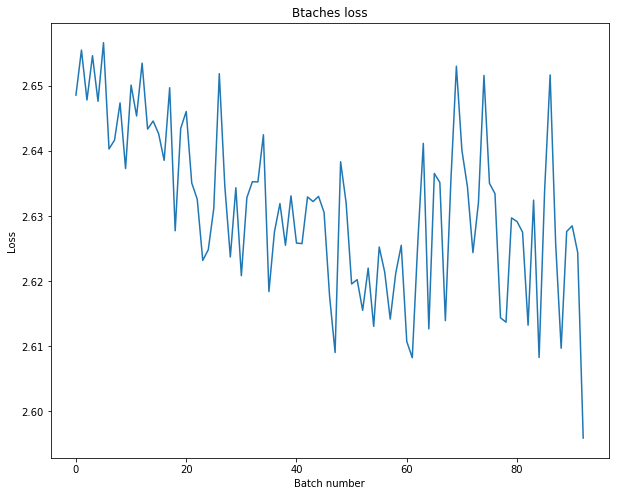

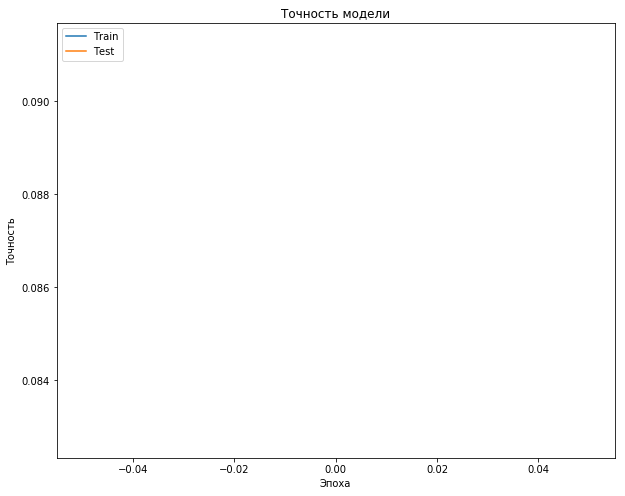

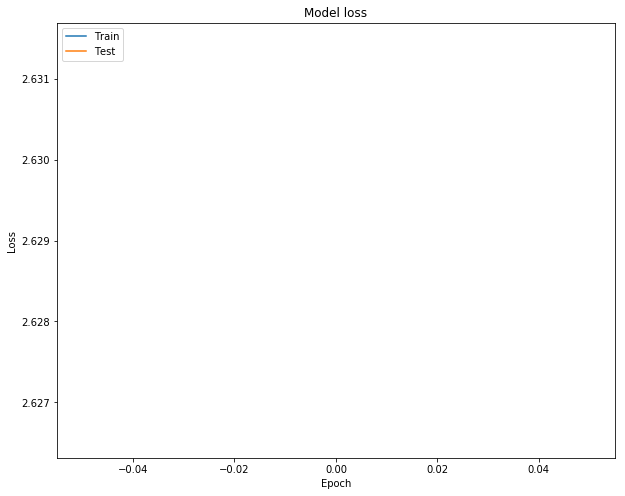

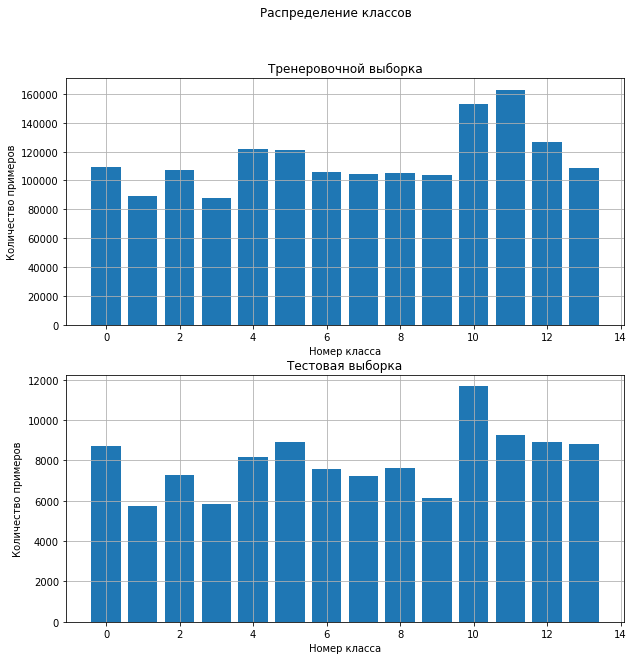

In [174]:
import torch.nn.utils.rnn as rnnUtils
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleModel(66, 10, COUNT_GUESTURE, dropout=0.4)
model = model.to(cuda)

lossFunction = nn.CrossEntropyLoss(ignore_index = PAD)
optimizer = SGD(model.parameters(), 0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', verbose = True, factor = 0.9)

shuflIds = np.arange(len(trainDatasetX))
np.random.seed(RANDOM_SEED)

testX = preprocessedTestX
testY = preprocessedTestY

testY = rnnUtils.pad_sequence(testY, padding_value = PAD, batch_first = True)
testY = testY.view(-1)
testSize = testY.size(0) - torch.sum(testY == PAD).item()

historyTestAcc = []
historyTrainAcc = []

historyTestLoss = []
historyTrainLoss = []

history = []

for i in range(EPOCH_COUNT):
    np.random.shuffle(shuflIds)
    batchStart = 0
    correctPredict = 0.0
    totalLoss = 0.0
    totalSize = 0.0
    countBatch = 0
    while batchStart < len(trainDatasetX):
        countBatch += 1
        batchEnd = batchStart + EPOCH_SIZE
        ids = shuflIds[batchStart:-1] if batchEnd >= len(trainDatasetX)  else shuflIds[batchStart:batchEnd]
        ids = sorted(ids)
        batchStart = batchEnd
        batchTrain = preprocessedTrain[ids]
        batchTrain = list(zip(*batchTrain))

        batchTrainX = batchTrain[0]
        batchTrainY = batchTrain[1]

        paddedY = rnnUtils.pad_sequence(batchTrainY, padding_value = PAD, batch_first = True)
        paddedY = paddedY.view(-1)
        predictY = model(batchTrainX)
        predictY = predictY.view(-1,COUNT_GUESTURE)

        loss = lossFunction(predictY, paddedY)
        
    
        totalLoss += loss.item()
        
        acc = torch.argmax(predictY, 1)
        acc = torch.sum(acc == paddedY).item()
        correctPredict += acc
        totalSize += paddedY.size(0) - torch.sum(paddedY == PAD).item()
        
        history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        scheduler.step(totalLoss / countBatch)
        predictTest = model(testX)
        predictTest = predictTest.view(-1,COUNT_GUESTURE)
        acc = torch.argmax(predictTest, 1)
        acc = torch.sum(acc == testY).item()
        acc = acc / testSize
        historyTestAcc.append(acc)
    
        historyTrainAcc.append(correctPredict / totalSize)
    
        historyTrainLoss.append(totalLoss / countBatch)
    
        historyTestLoss.append(lossFunction(predictTest, testY).item())
    
        print("Train loss: %f"%historyTrainLoss[-1])
        print("Test loss: %f"%historyTestLoss[-1])
        print("Train acc: %f"%historyTrainAcc[-1])
        print("Test acc: %f"%historyTestAcc[-1])
        print("------------------")

OutputResults(historyTrainAcc, historyTestAcc, historyTrainLoss, historyTestLoss, history, countClassesPFTrain, countClassesPFTest, "SimpleModel",  len(trainDatasetX), len(testDatasetX) )

#Seq to Seq

## Модель

In [18]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnnUtils
import torch.nn.functional as F
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: " + device.type)

Device: cuda


### Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.dropout = dropout
        
        self.gru = nn.GRU(input_dim, hid_dim, n_layers, dropout = dropout, batch_first = True)

    def forward(self, input):
        outputs, hidden = self.gru(input)
        return hidden


### Decoder

In [0]:

    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first = False)
        
        self.out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, hidden = self.rnn(embedded, hidden)
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden
    


### Seq2Seq

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

## Предобработка данных

In [22]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
from sklearn import preprocessing
from sklearn import pipeline
import spacy
import torch
from sklearn.preprocessing import FunctionTransformer
from torchtext.data import Field, BucketIterator, Dataset, Example, Iterator

vocab = ["Grab.", "Tap.", "Expand.", "Pinch.", "Rotation right.", "Rotation left.", "Swipe Right.", "Swipe Left.", "Swipe Up.", "Swipe Down.", "Swipe X.", "Swipe V.", "Swipe pluse.", "Shake."]

spacy_en = spacy.load('en')

sos = np.ones((1, testDatasetX[0].shape[1]))
eos = np.zeros((1, testDatasetX[0].shape[1]))

def genPad(bigShape, currShape):
    result = np.zeros((bigShape[0] - currShape[0] + 1, currShape[1]))
    return result
    

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def preprocess_bones(bones, t):
    sortedBones = sorted(bones, key=lambda x: x.shape[0], reverse=True)
    result = [np.concatenate((sos, x, genPad(sortedBones[0].shape, x.shape))) for x in sortedBones]
    return result

fieldTag = Field(tokenize = tokenize_en, 
                 init_token = '<sos>', 
                 eos_token = '<eos>',
                 lower = True,
                 batch_first = False)

fieldBones = Field( sequential = False,
                    use_vocab = False,
                    postprocessing = preprocess_bones,
                    dtype = torch.float)
# prepare train data
tags = [vocab[y[0]] for y in trainDatasetY]

examples = [Example.fromlist(d, (("src", fieldBones), ("trg", fieldTag))) for d in zip(trainDatasetX, tags)]
preprocessedTrainDataset = Dataset(examples, (("src", fieldBones), ("trg", fieldTag)))


fieldTag.build_vocab(preprocessedTrainDataset, min_freq = 1)

iteratorTrainData = BucketIterator(preprocessedTrainDataset, shuffle = True, batch_size = EPOCH_SIZE, device=device)

# prepare test data
tags = [vocab[y[0]] for y in testDatasetY]

examples = [Example.fromlist(d, (("src", fieldBones), ("trg", fieldTag))) for d in zip(testDatasetX, tags)]
preprocessedTestDataset = Dataset(examples, (("src", fieldBones), ("trg", fieldTag)))

iteratorTestData = BucketIterator(preprocessedTestDataset, batch_size = EPOCH_SIZE, device=device)


## Обучение

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    acc_result = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        acc = torch.argmax(output, 1)
        acc_result += torch.sum(acc == trg).item() / acc.size(0)
        
    return epoch_loss / len(iterator), acc_result/len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    acc_result = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
            acc = torch.argmax(output, 1)
            acc_result += torch.sum(acc == trg).item() / acc.size(0)
        
    return epoch_loss / len(iterator), acc_result/len(iterator)

In [0]:
from torch.optim import Adam
import time
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

INPUT_DIM = testDatasetX[0].shape[1]
OUTPUT_DIM = len(fieldTag.vocab)
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', verbose = True, factor = 0.9)

PAD_IDX = fieldTag.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

CLIP = 1

best_valid_loss = float('inf')

historyTrainAcc = []
historyTrainLoss = []
historyTestAcc = []
historyTestLoss = []
historyBatchsLoss = []

for epoch in range(EPOCH_COUNT):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, iteratorTrainData, optimizer, criterion, CLIP)
    valid_loss, valid_acc = evaluate(model, iteratorTestData, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    scheduler.step(train_loss)
    
    historyTrainAcc.append(train_acc)
    historyTrainLoss.append(train_loss)
    
    historyTestAcc.append(valid_acc)
    historyTestLoss.append(valid_loss)
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Acc: {train_acc:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Acc: {valid_acc:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
OutputResults(historyTrainAcc, historyTestAcc, historyTrainLoss, historyTestLoss, historyBatchsLoss, countClassesTrain, countClassesTest, 
                  "Seq2Seq",
                  len(trainDatasetX), len(testDatasetX))

Epoch: 01 | Time: 1m 22s
	Train Loss: 1.214 | Acc: 0.507 | Train PPL:   3.366
	 Val. Loss: 1.432 | Acc: 0.404 |  Val. PPL:   4.189
Epoch: 02 | Time: 1m 23s
	Train Loss: 0.995 | Acc: 0.563 | Train PPL:   2.705
	 Val. Loss: 1.476 | Acc: 0.463 |  Val. PPL:   4.374
Epoch: 03 | Time: 1m 23s
	Train Loss: 1.022 | Acc: 0.546 | Train PPL:   2.779
	 Val. Loss: 1.318 | Acc: 0.386 |  Val. PPL:   3.738
Epoch: 04 | Time: 1m 24s
	Train Loss: 1.080 | Acc: 0.528 | Train PPL:   2.945
	 Val. Loss: 1.440 | Acc: 0.392 |  Val. PPL:   4.221
Epoch: 05 | Time: 1m 24s
	Train Loss: 1.041 | Acc: 0.530 | Train PPL:   2.833
	 Val. Loss: 1.448 | Acc: 0.387 |  Val. PPL:   4.256
Epoch: 06 | Time: 1m 24s
	Train Loss: 1.020 | Acc: 0.534 | Train PPL:   2.774
	 Val. Loss: 1.578 | Acc: 0.407 |  Val. PPL:   4.847
Epoch: 07 | Time: 1m 24s
	Train Loss: 1.084 | Acc: 0.521 | Train PPL:   2.955
	 Val. Loss: 1.201 | Acc: 0.465 |  Val. PPL:   3.324
Epoch: 08 | Time: 1m 24s
	Train Loss: 1.060 | Acc: 0.527 | Train PPL:   2.886
	 Val